In [2]:
import os

In [3]:
%pwd

'/Users/rociocuatecontzi/Desktop/programming/electricity-forecast/research'

In [4]:
os.chdir('../')


In [5]:
%pwd

'/Users/rociocuatecontzi/Desktop/programming/electricity-forecast'

In [6]:
from src.eForecaster.pipeline.prediction import PredictionPipeline
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt

In [7]:
moment_to_pred = [['2023-02-13 10:15:00']]
df = pd.DataFrame(moment_to_pred, columns=['datetime'])
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")

df2 = pd.DataFrame()
df2['hour'] = df['datetime'].dt.hour
df2['dayofweek'] = df['datetime'].dt.dayofweek
df2['quarter']  = df['datetime'].dt.quarter
df2['month']  = df['datetime'].dt.month
df2['year']  = df['datetime'].dt.year
df2['dayofyear']  = df['datetime'].dt.dayofyear
df2['minute']  = df['datetime'].dt.minute
#data = [hour[0], dayofweek[0], quarter[0], month[0], year[0], dayofyear[0], minute[0]]
#print(data)
#data = np.array(data).reshape(1, 7)


In [98]:
import os
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
#from src.eForecaster.entity.config_entity import PlotConfig
#from src.eForecaster.config.configuration import ConfigurationManager
from src.eForecaster import logger
from pathlib import Path
from dataclasses import dataclass
from src.eForecaster.constants import *
from eForecaster.utils.common import read_yaml, create_directories

@dataclass(frozen=True)
class PlotConfig:
    root_dir: Path
    model_path: Path
    test_data_path: Path
    train_data_path: Path
    scatterplot_path: Path
    target_column: str
    columns: str

class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        create_directories([self.config.artifacts_root])

    def get_plot_config(self) -> PlotConfig:
        config = self.config.plotting

        schema = self.schema
        create_directories([
            Path(config.root_dir)
        ])
        plot_config = PlotConfig(
            root_dir=config.root_dir,
            model_path = config.model_path,
            test_data_path = config.test_data_path,
            train_data_path = config.train_data_path,
            scatterplot_path = config.scatterplot_path,
            target_column = schema.TARGET_COLUMN.name,
            columns = schema.COLUMNS
        )
        return plot_config


class Plotting:
    def __init__(self, config: PlotConfig):
        self.config = config
    def create_datetime_df(self, start_date: str, end_date: str):
        start_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
        end_date = datetime.strptime(end_date,"%Y-%m-%d %H:%M:%S")
        datetime_df = pd.date_range(start_date, end_date, freq='15min')
        datetime_df = datetime_df.to_frame(index=False, name="datetime")
        return datetime_df
    
    def create_prediction_df(self, df):
        df['hour'] = df.datetime.dt.hour
        df['dayofweek'] = df.datetime.dt.dayofweek
        df['quarter'] = df.datetime.dt.quarter
        df['month'] = df.datetime.dt.month
        df['year'] = df.datetime.dt.year
        df['dayofyear'] = df.datetime.dt.dayofyear
        df['minute'] = df.datetime.dt.minute
        return df
        

    def get_prediction(self, df):
        df_copy = df.copy()
        model = joblib.load(self.config.model_path)
        df_to_predict = df[[item for item in self.config.columns.keys()]]
        prediction = model.predict(df_to_predict)
        df_copy['prediction'] = prediction
        return df_copy
    

    def get_lineplot(self, df):
        test_data = pd.read_csv(self.config.test_data_path)
        train_data = pd.read_csv(self.config.train_data_path)
        test_data["datetime"] = pd.to_datetime(test_data["datetime"], format="%Y-%m-%d %H:%M:%S")
        train_data["datetime"] = pd.to_datetime(train_data["datetime"], format="%Y-%m-%d %H:%M:%S")
        train_test = pd.concat([test_data, train_data])
        joined_df = df.merge(train_test, how='left', on='datetime')
        joined_df['set'] = joined_df['set'].fillna('N/A')
        colors = ["#3287AA", "#46A0D2"]
        custom_palette = sns.set_palette(sns.color_palette(colors))
        ax = sns.lineplot(data=joined_df, x='datetime', y='power', marker='o', markersize=4,
                          hue="set",
                          palette=custom_palette)
        ax = sns.lineplot(data=joined_df, x='datetime', y='prediction', 
                          label='prediction', color="#7dce74", alpha=0.8, marker='o', markersize=4)
        plt.title('Forecast')
        plt.xticks(rotation=45)
        ax.set_xlabel('Date')
        ax.set_ylabel('MW')
        plt.savefig(Path(self.config.scatterplot_path), bbox_inches='tight')
        plt.show()
        plt.clf() 


[2024-03-03 17:38:58,930: INFO: 3726093388: >>>>>> stage Plotting started <<<<<<]
[2024-03-03 17:38:58,999: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-03-03 17:38:59,010: INFO: common: yaml file: params.yaml loaded successfully]
[2024-03-03 17:38:59,034: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-03-03 17:38:59,051: INFO: common: created directory at: artifacts]
[2024-03-03 17:38:59,067: INFO: common: created directory at: artifacts/plotting]
               datetime  hour_x  dayofweek_x  quarter_x  month_x  year_x  \
0   2021-10-01 10:15:00      10            4          4       10    2021   
1   2021-10-01 10:30:00      10            4          4       10    2021   
2   2021-10-01 10:45:00      10            4          4       10    2021   
3   2021-10-01 11:00:00      11            4          4       10    2021   
4   2021-10-01 11:15:00      11            4          4       10    2021   
..                  ...     ...          ...    

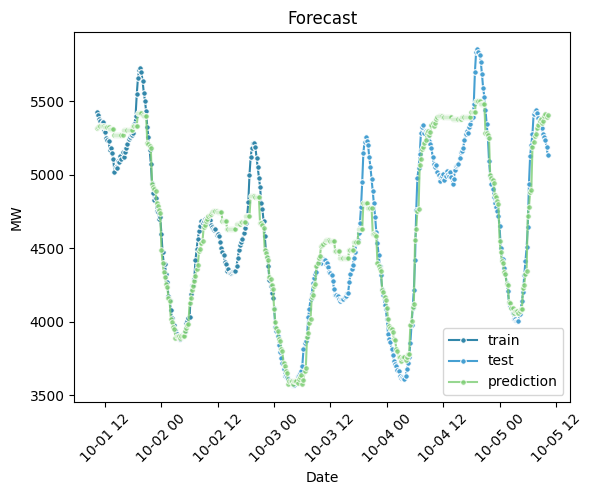

               datetime  hour  dayofweek  quarter  month  year  dayofyear  \
0   2021-10-01 10:15:00    10          4        4     10  2021        274   
1   2021-10-01 10:30:00    10          4        4     10  2021        274   
2   2021-10-01 10:45:00    10          4        4     10  2021        274   
3   2021-10-01 11:00:00    11          4        4     10  2021        274   
4   2021-10-01 11:15:00    11          4        4     10  2021        274   
..                  ...   ...        ...      ...    ...   ...        ...   
380 2021-10-05 09:15:00     9          1        4     10  2021        278   
381 2021-10-05 09:30:00     9          1        4     10  2021        278   
382 2021-10-05 09:45:00     9          1        4     10  2021        278   
383 2021-10-05 10:00:00    10          1        4     10  2021        278   
384 2021-10-05 10:15:00    10          1        4     10  2021        278   

     minute   prediction  
0        15  5316.158203  
1        30  5323.652

<Figure size 640x480 with 0 Axes>

In [99]:
STAGE_NAME = "Plotting"
class PlottingPipeline:
    def __init__(self):
        pass

    def main(self):
        config = ConfigurationManager()
        plot_config = config.get_plot_config()
        plotting = Plotting(config=plot_config)
        datetime_df = plotting.create_datetime_df("2021-10-01 10:15:00", "2021-10-05 10:15:00")
        prediction_df = plotting.create_prediction_df(datetime_df)
        predicted_df = plotting.get_prediction(prediction_df)
        plotting.get_lineplot(predicted_df)
        #print(datetime_df)
        print(predicted_df)


if __name__ == '__main__':
    try:
        logger.info(f">>>>>> stage {STAGE_NAME} started <<<<<<")
        obj = PlottingPipeline()
        obj.main()
        logger.info(f">>>>>> stage {STAGE_NAME} completed <<<<<<\n\nx==========x")
    except Exception as e:
        logger.exception(e)
        raise e

In [59]:
print(sns.color_palette("pastel6").as_hex())

['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']


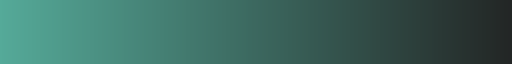

In [61]:
sns.color_palette("dark:#5A9_r", as_cmap=True)

In [76]:
#datetime_object = datetime.strptime(moment_to_pred, "%Y-%m-%d %H:%M:%S")
#datetime_object

TypeError: strptime() argument 1 must be str, not list

In [90]:
print(moment_to_pred)

[['2023-02-13 10:15:00']]


In [91]:
df2

,hour,dayofweek,quarter,month,year,dayofyear,minute
0,10,0,1,2,2023,44,15


In [92]:
obj = PredictionPipeline()
predict = obj.predict(df2)
print(predict)

[5911.8594]


In [73]:
print(str(predict))

[5324.0454]


In [10]:
from eForecaster.constants import *
from eForecaster.utils.common import read_yaml, create_directories, save_json


In [23]:

config_filepath = CONFIG_FILE_PATH,
params_filepath = PARAMS_FILE_PATH,
schema_filepath = SCHEMA_FILE_PATH

schema = read_yaml(schema_filepath)


schema2 =  schema.TARGET_COLUMN.name
schema3 = []
for item in schema.COLUMNS.keys():
    schema3.append(item)
schema4 = [item for item in schema.COLUMNS.keys()]

print(schema2)
print(schema3)
print(schema4)

[2024-01-28 13:32:33,578: INFO: common: yaml file: schema.yaml loaded successfully]
power
['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'minute']
['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'minute']


In [18]:
from datetime import date, timedelta
import pandas as pd
import os
from pathlib import Path


In [26]:
df = pd.read_csv('./artifacts/data_ingestion/ver_data.csv', sep=';', decimal=',')
before_symbol = df['datetime'].str.split('+').str[0]
df["datetime"] = pd.to_datetime(before_symbol, format="%Y.%m.%d %H:%M:%S ")
df.set_index('datetime', inplace=True)

df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['minute'] = df.index.minute


Timestamp('2021-10-03 00:00:00')

In [27]:
today = date.today()
d = timedelta(days=365)
start_date = df.index[-1] - d #One year before the last date in the dataset
start_date = start_date.strftime("%Y-%m-%d")
start_date

'2021-10-03'